## Problem Statement:

Loans provide the opportunity to link up lenders with those in need of capital. The investors make profit due to interest tacked onto the loan. However, not all loans see their principal paid until the end, and when the loan is not paid-in-full (PIF) then the loan is charged-off. When this occurs, the lender loses money and due to the chance of charge-off when it comes to personal loans, it is imperative that the platforms providing this link between lenders and borrowers have a risk model to mitigate potential charge-off based on borrower information. This study aims to train several machine learning models to classify if a borrower will repay the loan or potentially charge-off using Lending Tree data from 2007 - 2015. The guiding metric will be the area under the ROC curve (AUC), specifically the precision-recall AUC score. 
    

Minimizes costs spent in collection efforts as well as legal fees. Attract investors as they will have peace of mind that their money is not at risk when it is in the hands of a lending platform such as Lending Club. With the ability to discern if a borrower will Lenders can use different methods to assess the level of credit risk of a potential borrower in order to mitigate losses and avoid delayed payments, such as having higher interest loans as a way to mitigate against high risk loans. 

Possible Risks and Assumptions:

- Data comes from Kaggle and is application data, there can be missing data at random
- Both linear and non-linear relationships between variables which we can address in models
- Multicollinearity in our dependent variables due to many of them being credit-related (card utilization, accounts present)
- Data is coming from Lending Club which may have a certain limitation of scope, mainly personal loans capped at 40_000 which doesn't reflect all types of loans and loan amounts
- We would assume our observations/specific loan data are independent (can check to see if there are renewal loans...perhaps shared ID)

## Data Imports and Cleaning

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline

In [3]:
# Reading in our data from Kaggle, all accepted loans from 2007 to 2018 Q4
loan = pd.read_csv('./data/accepted_2007_to_2018Q4.csv')

C:\Users\eddie\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


We are reducing the number of features to those that will be present to an investor when presented with a loan application. This would include information such as the loan amount, term of the loan, interest rate, debt-to-income ratio, FICO score, and basic credit history. There were multiple features in the original data set for secondary applicants as there were loans for joint applications. For this study, we will solely model using individual loans and their associated applicant information. 

In [4]:
col_list = ['loan_amnt', 'term', 'int_rate', 'installment',
       'emp_length', 'home_ownership', 'annual_inc', 'issue_d', 'loan_status',
       'purpose', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'total_acc', 'pub_rec', 'revol_bal', 'earliest_cr_line',
       'revol_util', 'last_fico_range_high',
       'last_fico_range_low', 'application_type', 'acc_now_delinq',
       'avg_cur_bal', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens', 'mort_acc']

In [5]:
#Dropping all features not listed in code above
loan = loan[col_list]

In [6]:
loan['issue_d'] = pd.to_datetime(loan['issue_d'])

In [7]:
loan.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,issue_d,loan_status,purpose,...,last_fico_range_high,last_fico_range_low,application_type,acc_now_delinq,avg_cur_bal,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,mort_acc
0,3600.0,36 months,13.99,123.03,10+ years,MORTGAGE,55000.0,2015-12-01,Fully Paid,debt_consolidation,...,564.0,560.0,Individual,0.0,20701.0,0.0,0.0,0.0,0.0,1.0
1,24700.0,36 months,11.99,820.28,10+ years,MORTGAGE,65000.0,2015-12-01,Fully Paid,small_business,...,699.0,695.0,Individual,0.0,9733.0,0.0,0.0,0.0,0.0,4.0
2,20000.0,60 months,10.78,432.66,10+ years,MORTGAGE,63000.0,2015-12-01,Fully Paid,home_improvement,...,704.0,700.0,Joint App,0.0,31617.0,0.0,0.0,0.0,0.0,5.0
3,35000.0,60 months,14.85,829.90,10+ years,MORTGAGE,110000.0,2015-12-01,Current,debt_consolidation,...,679.0,675.0,Individual,0.0,23192.0,0.0,0.0,0.0,0.0,1.0
4,10400.0,60 months,22.45,289.91,3 years,MORTGAGE,104433.0,2015-12-01,Fully Paid,major_purchase,...,704.0,700.0,Individual,0.0,27644.0,0.0,0.0,0.0,0.0,6.0


In [8]:
loan.shape

(2260701, 31)

Here, we see that the raw dataset has '2,260,701' loans, which we've reduced to 32 features, including our predicted value ('loan_status'). 

In [9]:
def data_summary(df):
    features = []
    dtypes = []
    unique = []
    null_values = []
    for c in df.columns:
        features.append(c)
        dtypes.append(df[c].dtype)
        unique.append(df[c].nunique())
        null_values.append(df[c].isna().sum())
    dict = {
        'feature' : features,
        'dtype' : dtypes,
        'unique_val' : unique,
        'null_values': null_values
    }
    data = pd.DataFrame(dict)
    return data

In [10]:
data_summary(loan).sort_values('dtype', ascending = False)

,feature,dtype,unique_val,null_values
9,purpose,object,14,33
5,home_ownership,object,6,33
1,term,object,2,33
23,application_type,object,2,33
8,loan_status,object,9,33
19,earliest_cr_line,object,754,62
4,emp_length,object,11,146940
27,delinq_amnt,float64,2617,62
26,chargeoff_within_12_mths,float64,11,178
18,revol_bal,float64,102251,33


#### Setting Up Our Predicted Value

In [11]:
#Slicing our dataframe so that it only contains loans which are fully paid off or charged-off
loan = loan.loc[loan['loan_status'].isin(['Fully Paid', 'Charged Off'])]

loan['loan_status'] = loan['loan_status'].map({
    'Fully Paid': 0,
    'Charged Off': 1
})

loan.loan_status.value_counts(dropna = False)

0    1076751
1     268559
Name: loan_status, dtype: int64

In [12]:
loan.shape

(1345310, 31)

This has reduced the number of samples we have for our model as we originally started with 2,260,701 loans. This amounts to about ~60% of our original dataset but we are not too concerned as our sample size is still significant. 

#### Cleaning Categorical Columns

In [13]:
for c in loan.columns:
    if loan[c].dtype == 'object':
        print(f'Feature: {c}')
        print(f'% of Null Values:{loan[c].isna().sum() / len(loan[c])}')
        print('Value Counts:')
        print(loan[c].value_counts(dropna = False))
        print('---------')

Feature: term
% of Null Values:0.0
Value Counts:
 36 months    1020743
 60 months     324567
Name: term, dtype: int64
---------
Feature: emp_length
% of Null Values:0.058359039923883714
Value Counts:
10+ years    442199
2 years      121743
< 1 year     108061
3 years      107597
1 year        88494
5 years       84154
4 years       80556
NaN           78511
6 years       62733
8 years       60701
7 years       59624
9 years       50937
Name: emp_length, dtype: int64
---------
Feature: home_ownership
% of Null Values:0.0
Value Counts:
MORTGAGE    665579
RENT        534421
OWN         144832
ANY            286
OTHER          144
NONE            48
Name: home_ownership, dtype: int64
---------
Feature: purpose
% of Null Values:0.0
Value Counts:
debt_consolidation    780321
credit_card           295279
home_improvement       87504
other                  77875
major_purchase         29425
medical                15554
small_business         15416
car                    14585
moving           

In [14]:
loan.application_type.value_counts(normalize = True)

Individual    0.980822
Joint App     0.019178
Name: application_type, dtype: float64

To start, let's remove the joint applications from our data set which we can see is a very miniscule subset of our loans. It comes out to be around 2% of all loan applications and with this severe imbalance, it would benefit to remove this feature. In addition to this, in terms of our initial goal, we will build a model using only individual information to predict loan repayment.|

In [16]:
loan = loan[loan.application_type == 'Individual']

In [16]:
loan.term.value_counts()

 36 months    1004477
 60 months     315033
Name: term, dtype: int64

In [17]:
loan.application_type.value_counts()

Individual    1319510
Name: application_type, dtype: int64

In [15]:
loan = loan[loan.application_type == 'Individual']
loan['application_type'].value_counts(dropna = False)

Individual    1319510
Name: application_type, dtype: int64

In [20]:
loan.home_ownership.value_counts(dropna = False)

MORTGAGE    648107
RENT        528509
OWN         142418
ANY            286
OTHER          144
NONE            46
Name: home_ownership, dtype: int64

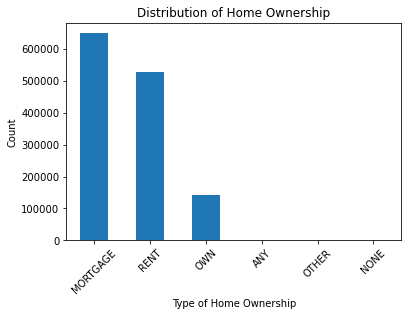

<Figure size 720x648 with 0 Axes>

In [36]:
loan['home_ownership'].value_counts().plot(kind = 'bar')
plt.xlabel('Type of Home Ownership')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.title('Distribution of Home Ownership')
plt.figure(figsize = (10,9));

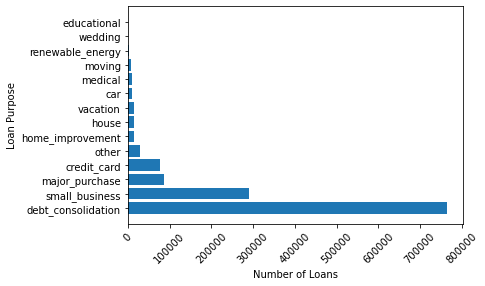

In [55]:
plt.barh(loan['purpose'].unique(), loan['purpose'].value_counts())
plt.xlabel('Number of Loans', size = 10)
plt.ylabel('Loan Purpose', size = 10)
plt.xticks(rotation = 45);

In [58]:
loan['earliest_cr_line'] = pd.to_datetime(loan['earliest_cr_line'])
loan['earliest_cr_line_year'] = loan['earliest_cr_line'].dt.year
loan['year'] = loan['issue_d'].dt.year
loan['credit_file_age'] = loan['year'] - loan['earliest_cr_line_year']

(array([  1813.,   4716.,  11536.,  21721.,  53367., 134804., 223102.,
        375144., 287809., 205498.]),
 array([2007. , 2008.1, 2009.2, 2010.3, 2011.4, 2012.5, 2013.6, 2014.7,
        2015.8, 2016.9, 2018. ]),
 <BarContainer object of 10 artists>)

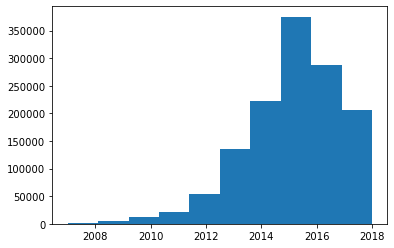

In [75]:
plt.hist(loan['year'])

(array([2.67906e+05, 6.43340e+05, 2.75076e+05, 9.88500e+04, 2.66590e+04,
        6.64900e+03, 9.42000e+02, 7.90000e+01, 8.00000e+00, 1.00000e+00]),
 array([ 3., 11., 19., 27., 35., 43., 51., 59., 67., 75., 83.]),
 <BarContainer object of 10 artists>)

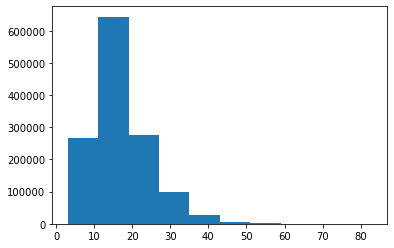

In [78]:
plt.hist(loan['credit_file_age'])

In [81]:
loan.drop(columns = ['earliest_cr_line', 'application_type', 'year', 'earliest_cr_line_year'], inplace = True)

In [82]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1319510 entries, 0 to 2260697
Data columns (total 30 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   loan_amnt                 1319510 non-null  float64       
 1   term                      1319510 non-null  int64         
 2   int_rate                  1319510 non-null  float64       
 3   installment               1319510 non-null  float64       
 4   emp_length                1319510 non-null  object        
 5   home_ownership            1319510 non-null  object        
 6   annual_inc                1319510 non-null  float64       
 7   issue_d                   1319510 non-null  datetime64[ns]
 8   loan_status               1319510 non-null  int64         
 9   purpose                   1319510 non-null  object        
 10  dti                       1319510 non-null  float64       
 11  delinq_2yrs               1319510 non-null  float6

In [18]:
emp_length_dict = {
    '< 1 year' : '<1 year',
    '1 year'   : '1-5 years',
    '2 years'  : '1-5 years',
    '3 years'  : '1-5 years',
    '4 years'  : '1-5 years',
    '5 years'  : '1-5 years',
    '6 years'  : '5-10 years',
    '7 years'  : '5-10 years',
    '8 years'  : '5-10 years',
    '9 years'  : '5-10 years',
    '10+ years': '10+ years',
    np.nan     : 'N/A'
}

loan.emp_length = loan.emp_length.map(emp_length_dict)

In [ ]:
loan.purpose.value_counts(dropna = False)

In [85]:
loan[['last_fico_range_high', 'last_fico_range_low']]

,last_fico_range_high,last_fico_range_low
0,564.0,560.0
1,699.0,695.0
4,704.0,700.0
5,759.0,755.0
6,654.0,650.0
...,...,...
2260688,709.0,705.0
2260690,719.0,715.0
2260691,499.0,0.0
2260692,684.0,680.0


In [87]:
loan['fico'] = loan[['last_fico_range_high', 'last_fico_range_low']].mean(axis = 1)

In [89]:
loan[['fico', 'last_fico_range_high', 'last_fico_range_low']]

,fico,last_fico_range_high,last_fico_range_low
0,562.0,564.0,560.0
1,697.0,699.0,695.0
4,702.0,704.0,700.0
5,757.0,759.0,755.0
6,652.0,654.0,650.0
...,...,...,...
2260688,707.0,709.0,705.0
2260690,717.0,719.0,715.0
2260691,249.5,499.0,0.0
2260692,682.0,684.0,680.0


#### Missing Values

In [91]:
null_count = []
for columns in loan.columns[0:100]:
    if loan[columns].isna().sum() != 0:
        print('FEATURE NAME:')
        print(columns)
        print('NULL VALUE COUNT:')
        print(loan[columns].isna().sum())
        print('PERCENT OF ALL VALUES:')
        print(loan[columns].isna().sum() / len(loan[columns]))
        print('~~~~~~~~~~~~~~~~~~~')
        null_count.append([columns, loan[columns].isna().sum(), loan[columns].isnull().mean()])
null_values = pd.DataFrame(null_count, columns = ['Feature', 'Null Value Count', 'Percentage of Data'])

FEATURE NAME:
inq_last_6mths
NULL VALUE COUNT:
1
PERCENT OF ALL VALUES:
7.578570833112292e-07
~~~~~~~~~~~~~~~~~~~
FEATURE NAME:
revol_util
NULL VALUE COUNT:
812
PERCENT OF ALL VALUES:
0.000615379951648718
~~~~~~~~~~~~~~~~~~~
FEATURE NAME:
avg_cur_bal
NULL VALUE COUNT:
67546
PERCENT OF ALL VALUES:
0.051190214549340286
~~~~~~~~~~~~~~~~~~~
FEATURE NAME:
chargeoff_within_12_mths
NULL VALUE COUNT:
56
PERCENT OF ALL VALUES:
4.2439996665428835e-05
~~~~~~~~~~~~~~~~~~~
FEATURE NAME:
pub_rec_bankruptcies
NULL VALUE COUNT:
697
PERCENT OF ALL VALUES:
0.0005282263870679268
~~~~~~~~~~~~~~~~~~~
FEATURE NAME:
tax_liens
NULL VALUE COUNT:
39
PERCENT OF ALL VALUES:
2.9556426249137938e-05
~~~~~~~~~~~~~~~~~~~
FEATURE NAME:
mort_acc
NULL VALUE COUNT:
47281
PERCENT OF ALL VALUES:
0.035832240756038226
~~~~~~~~~~~~~~~~~~~


In [95]:
loan['inq_last_6mths'].value_counts(dropna = False)

0.0    753705
1.0    360217
2.0    134758
3.0     51150
4.0     13796
5.0      4872
6.0       941
7.0        48
8.0        22
NaN         1
Name: inq_last_6mths, dtype: int64

In [96]:
loan[loan['inq_last_6mths'].isnull()]

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,issue_d,loan_status,purpose,...,last_fico_range_low,acc_now_delinq,avg_cur_bal,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,mort_acc,credit_file_age,fico
1099335,35000.0,1,9.8,740.21,10+ years,MORTGAGE,110000.0,2016-01-01,0,debt_consolidation,...,805.0,0.0,23547.0,0.0,0.0,0.0,0.0,4.0,22,807.0


In [ ]:
#null_values.sort_values('Null Value Count', ascending = False).head(50)

In [ ]:
#null_values.sort_values('Null Value Count', ascending = False).tail(26)

In [ ]:
#bad_cols = loan.columns[loan.isnull().mean() > 0.5]

In [ ]:
#loan.drop(columns = bad_cols, inplace = True)

Dealing with null values:
- Possibly remove missing values (not recommended)
- Impute null with median
- Longer: Find relationship between features that share similar number of null values to see if there is a pattern and determine what can be imputed to reflect accurate info from participant (we can see this for number of accounts so it does not appear to be completely at random..just a guess)
- Checking correlation between features to drop ones that are experiencing severe multicollinearity

In [ ]:
loan.reset_index(drop = True)

In [ ]:
loan['application_type'].value_counts(dropna = False)

In [ ]:
for c in loan.columns:
    if loan[c].dtype == 'object':
        print(c)
        print(loan[c].isna().sum())

In [ ]:
loan

In [ ]:
loan['loan_status'].mean()

Loan grade is the specific grade assigned by Lending Club. We would want to remove this from our model since it does not meet our requirements for the feature. We want to build a model that takes in information that is known when the borrower applies and including Lending Club's rating of a loan application would only hurt our model. It would include Lending Club's own rating of a loan based on the loan information. For now we can leave it out and possibly compare it to our own model. 

In [ ]:
loan.term.value_counts(dropna = False)

In [ ]:
#loan.drop(columns = ['emp_title'], inplace = True)

In [ ]:
for c in loan.columns:
    if loan[c].dtype == 'object':
        print(c)

In [ ]:
loan.emp_length.value_counts(dropna = False, normalize = True)

To 

In [ ]:
emp_length_dict = {
    '< 1 year' : '<1 year',
    '1 year'   : '1-5 years',
    '2 years'  : '1-5 years',
    '3 years'  : '1-5 years',
    '4 years'  : '1-5 years',
    '5 years'  : '1-5 years',
    '6 years'  : '5-10 years',
    '7 years'  : '5-10 years',
    '8 years'  : '5-10 years',
    '9 years'  : '5-10 years',
    '10+ years': '10+ years',
}

In [ ]:
loan.emp_length = loan.emp_length.map(emp_length_dict)

In [ ]:
loan.emp_length.value_counts(dropna = False, normalize = True)

In [ ]:
not_employed = len(loan[loan.emp_title.isnull()])

In [ ]:
not_employed

In [ ]:
loan[loan.emp_title.isnull()].groupby('emp_length')['emp_length'].count().sort_values() / not_employed

We can see that for those that have no employment title provided also happen to be ~90% of those that reported no employment length. This may show that those with no employment length are never employed, self-employed, students or possibly retired. Due to this, we will keep these values of 'n/a' in employment length as their own category. We will be dropping the emp_title column due to the high number of unique titles (371,436).

In [ ]:
len(loan.emp_title.unique())

In [ ]:
loan.info()

In [ ]:
loan[['fico_range_high', 'fico_range_low']]

In [ ]:
loan['emp_length'].sort_values()

In [ ]:
loan.home_ownership.value_counts(dropna = False)

In [ ]:
for c in loan.columns:
    if loan[c].dtype == 'object':
        print(c)

In [ ]:
plt.hist(loan.loan_amnt, bins = 10)
plt.axvline(np.mean(loan.loan_amnt), color = 'red')
plt.xlabel('Loan Amount in USD')
plt.ylabel('Values')
plt.title('Distribution of Loan Amount');

In [ ]:
plt.hist(loan.int_rate, bins = 15)
plt.axvline(np.mean(loan.int_rate), color = 'red')
plt.xlabel('Interest Rate')
plt.ylabel('Values')
plt.title('Distribution of Interest Rate');

In [ ]:
plt.hist(loan.installment, bins = 15)
plt.axvline(np.mean(loan.installment), color = 'red')
plt.xlabel('Payment Installment Size')
plt.title('Distribution of Installment Size');

In [ ]:
plt.hist(loan.annual_inc, bins = 2000)
plt.axvline(np.mean(loan.annual_inc), color = 'red')
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.xlabel('Annual Income in USD')
plt.ylabel('Values')
plt.title('Distribution of Annual Income');

In [ ]:
log_annual = np.log(loan.annual_inc)

In [ ]:
loan[loan.annual_inc == 0.0][

In [ ]:
plt.hist(log_annual)
plt.axvline(np.log(np.mean(loan.annual_inc)), color = 'red')
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.xlabel('Annual Income in USD')
plt.ylabel('Values')
plt.title('Distribution of Annual Income');

In [ ]:
sns.catplot(x = 'loan_status', kind = 'count', data = loan)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.title('Loan Status Breakdown')
plt.xlabel('Loan Status');

Large class imbalance we can see with our dependent variable. Loans that charged-off amount to 261,655 and loans that were fully paid amount to 1,041,952. In simple terms, there are ~4 times as many examples of loans that were fully paid off. Due to the class imbalance, we probably would not use our accuracy score considering if we guessed for all the loans to be fully paid off, we would be accurate at 79.93%. With that, we will use the precision-recall AUC score as it evaluates the faction of true positives among positive predictions.

In [ ]:
1041952/261655

In [ ]:
loan.describe().T.head(30)

### Models:
- Log Reg, tune for regularization
- Random Forest Classifier, bagging, diverse set of potential trees to be built
- KNN
- Naive Bayes(?) - independence of features, need to deal with multicoll.
- SVM
- Deep Neural Network